# Objective

## Problem to solve

Story generator using GRU (and possibly a LSTM).

## Dataset

Plaintext books downloaded from https://www.gutenberg.org/ from the following authors:
* Fyodor Dostoyevsky
    * Crime and Punishment
    * The Brothers Karamazov
* Oscar Wilde
    * The Canterville Ghost
    * The Importance of Being Earnest
    * The Picture of Dorian Gray
    * The Soul of Man under Socialism

Fryodor Dostoyevsky books are the **main** dataset we want to use for training (3.7MB of text). While Oscar Wilde books were used for quicker experimentation as the dataset is smaller (712KB of text).

Though we can really download books from any author to train the model to generate stories in that author's "style".

In [1]:
from rnn_story_gen import *

2025-12-06 17:50:33.507166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 17:50:33.544571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 17:50:34.272676: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Exploratory Data Analysis

Note that the books were already manually stripped of non-story sections like:
* Table of contents
* Licence
* etc...

In [2]:
text = load_text_data("data/rnn/fyodor_dostoyevsky")
perform_eda(text)

Loading text data from data/rnn/fyodor_dostoyevsky...
  - Reading crime_and_punishment.txt...
  - Reading the_brothers_karamazov.txt...
Total characters loaded: 3061046
EXPLORATORY DATA ANALYSIS
Total Characters: 3061046
Vocabulary Size:  99
Vocabulary:       '\n !()*,-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyzÆàäæçèéêëîïôöüŒœ‐—‘’“”'
----------------------------------------
Top 20 Most Common Characters:
  ' ': 504379 (16.48%)
  'e': 279963 (9.15%)
  't': 211127 (6.90%)
  'a': 188296 (6.15%)
  'o': 188228 (6.15%)
  'n': 160896 (5.26%)
  'i': 148563 (4.85%)
  'h': 148433 (4.85%)
  's': 138705 (4.53%)
  'r': 123619 (4.04%)
  'd': 101956 (3.33%)
  'l': 95661 (3.13%)
  'u': 72438 (2.37%)
  'm': 60151 (1.97%)
  '\n': 59047 (1.93%)
  'y': 57187 (1.87%)
  'w': 51480 (1.68%)
  'c': 49049 (1.60%)
  'f': 46803 (1.53%)
  ',': 46469 (1.52%)
----------------------------------------
First 500 Characters (Check for headers):
----------------------------------------
CRIME AN

## Findings
*   **Volume:** 3.06M characters (~3MB). Sufficient for character-level learning of style and grammar.
*   **Vocabulary:** 99 unique characters. Includes standard alphanumeric, some foreign accents, and typographic punctuation (smart quotes, em-dashes).
*   **Cleanliness:** No Project Gutenberg headers or footers found. Manual cleaning was successful.
*   **Distribution:** Standard English letter frequency (Space ~16%, 'e' ~9%).

The dataset is clean, has a relatively good size, without sacrificing training speed for a Laptop GPU.

# Pre-processing

The preprocessing pipeline for the RNN story generator involves two main steps:

1.  **Text Vectorization:**
    *   A unique vocabulary of all characters in the dataset is created and sorted.
    *   Each character is mapped to a unique integer index (e.g., 'a' -> 0, 'b' -> 1).
    *   The entire raw text is converted into a sequence of these integer indices.
<br>

2.  **Dataset Creation:**
    *   The vectorized text is segmented into sequences of a predefined length (`seq_length`).
    *   For each sequence, input and target pairs are formed: the input is `seq_length` characters long, and the target is the same sequence shifted by one character (predicting the next character).
    *   These input-target pairs are then shuffled and batched into a `tf.data.Dataset` for efficient model training.


In [3]:
seq_length = 100
batch_size = 64

text_as_int, vocab, char2idx, idx2char, vocab_size = preprocess_text(text)
dataset = create_dataset(text_as_int, 100, 64, buffer_size=10000)

Preprocessing text...
Vocabulary size: 99 unique characters
Creating dataset (seq_length=100, batch_size=64)...


I0000 00:00:1765065037.332758   34995 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# Model definition

## Architecture

The model implements a standard character-level Recurrent Neural Network (RNN) using the following architecture:

1.  **Embedding Layer (Input):**
    *   **Input Dimension:** `vocab_size`.
    *   **Output Dimension:** `embedding_dim` (256).
    *   **Purpose:** Converts integer-encoded characters into dense vectors of fixed size. This allows the model to learn semantic relationships between characters (e.g., vowels might end up clustered together in this vector space).

2.  **GRU Layer (Hidden):**
    *   **Type:** Gated Recurrent Unit (`tf.keras.layers.GRU`).
    *   **Units:** 1024.
    *   **Return Sequences:** `True` (Outputs a prediction for *every* time step in the sequence, not just the final one).
    *   **Purpose:** GRU is chosen over simple RNNs to solve the vanishing gradient problem, allowing the model to capture longer-term dependencies.

3.  **Dense Layer (Output):**
    *   **Units:** `vocab_size`.
    *   **Purpose:** Outputs the raw logits for the next character in the sequence.


In [8]:
embedding_dim = 256
rnn_units = 1024

model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size
)

model.summary()

Building model (vocab_size=99, rnn_units=1024, stateful=False)...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (64, None, 256)        │        25,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (64, None, 1024)       │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, None, 99)         │       101,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,065,123 (15.51 MB)

 Trainable params: 4,065,123 (15.51 MB)

 Non-trainable params: 0 (0.00 B)

# Training

## Configuration
*   **Epochs:** 20
*   **Optimizer:** Adam
*   **Loss Function:** `sparse_categorical_crossentropy` (from logits=True)
*   **Batch Size:** 64
*   **Sequence Length:** 100
*   **Checkpointing:** Model weights saved every 3 epochs to `./rnn_checkpoints`.

## Observations
*   **Convergence:** The loss curve started to flatten towards the later epochs, suggesting the model is converging.
*   **Quality Threshold:** A final loss of `0.87` is indicative of a model that has likely learned good grammatical structure and stylistic elements, without necessarily having overfit to the point of memorizing the training text verbatim.


Training RNN model (saving every 3 epochs)...
Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 1.9773
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.3530
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2478
Saving checkpoint to ./rnn_checkpoints/ckpt_3.weights.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 1.2310
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.1716
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.1302
Epoch 6/20
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0968
Saving checkpoint to ./rnn_checkpoints/ckpt_6.weights.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 1.0972
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.0691
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 1.0431
Epoch 9/20
471/473 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0136
Saving checkpoint to ./rnn_checkpoints/ckpt_9.weights.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - los

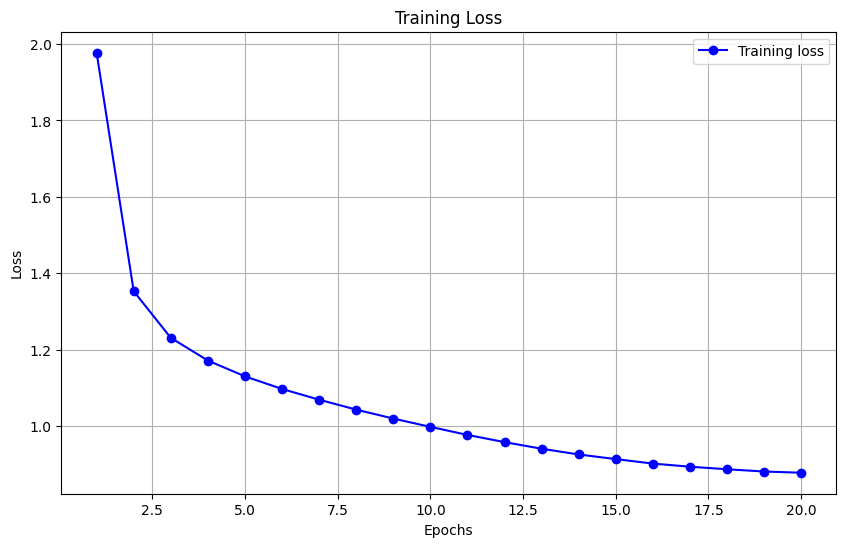

In [9]:
load_checkpoint = False
epochs = 20
checkpoint_dir = './rnn_checkpoints'

if load_checkpoint:
    model.load_weights(checkpoint_dir + '/ckpt_18.weights.h5')
    epochs = 2

history = train_model(model, dataset, epochs, checkpoint_dir)
plot_training_history(history)

# Evaluation and Results

## Text Generation with Temperature Sweeping (Qualitative)
*   We will generate text using the trained model, varying the `temperature` parameter (e.g., 0.2, 0.6, 1.0, 1.4).
*   This demonstrates the model's ability to produce outputs ranging from conservative and coherent (low temperature) to creative and diverse (higher temperature).
*   This will serve as a form of "Turing Test": if the generated text is stylistically convincing and similar to the original author's writing.

In [10]:
seed_text = "The"
generate_length = 500

# Rebuild the model with `batch_size=1` and `stateful=True` for generation
model_gen = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1, stateful=True)
model_gen.set_weights(model.get_weights())

Building model (vocab_size=99, rnn_units=1024, stateful=True)...


### Temperature = 0.2

* **Syntactic Correctness**: Complex sentence structures, proper punctuation, and accurate word usage.
* **Semantic Coherence**: Some individual sentences almost make sense, but the overall text is nonsensical.
* **Stylistic Fidelity**: It does feel like the original author style, but maybe he had too much to drink when writing this.
* **Creativity vs. Memorization**: Creativity. Could not find the generated sentences in the original books.

In [16]:
story = generate_text(model_gen, seed_text, char2idx, idx2char, generate_length, temperature=0.2)
print("-" * 80, story, "-" * 80, sep="\n")


Generating 500 characters with seed 'The' (temp=0.2)...
--------------------------------------------------------------------------------
There was no one in the town who had been able to show his
heart all his life. What are you doing? What if he had to put up with
that time, and what he has seen the money? So then there is a
scoundrel, but as a man of the sort, a man who has just said
something his hands again. The prisoner has a fine time perhaps that
she has to do it. The priest and the hope of his being under the
pillow. I want to speak to him and see what I am afraid of. There was
nothing to do that letter at the time with the 
--------------------------------------------------------------------------------


### Temperature = 0.6

* **Syntactic Correctness**: Proper sentence structures, proper punctuation, and accurate word usage.
* **Semantic Coherence**: Some individual sentences still make a bit of sense. Overall nonsense.
* **Stylistic Fidelity**: Very drunk Dostoyevski, but it is still him.
* **Creativity vs. Memorization**: Creativity starting to descend into madness.

In [17]:
story = generate_text(model_gen, seed_text, char2idx, idx2char, generate_length, temperature=0.6)
print("-" * 80, story, "-" * 80, sep="\n")


Generating 500 characters with seed 'The' (temp=0.6)...
--------------------------------------------------------------------------------
There was no one to draw up the birls, but with
truth like that if she did so easily, that he knew only from a desperate hatred
and a half. But we all knew that he wanted to find out whether he went
in and went to the floor. Alyosha went out of the business of
the past before the valet and to wait an hour before, and he looked
somewhat in his face, she had a softhy laughter round him.
The first letter was talking later, and he suddenly felt that he had been
formed anything before his dreams and the
--------------------------------------------------------------------------------


### Temperature = 1.0

* **Syntactic Correctness**: It is starting to make up words, but the text still has proper structure.
* **Semantic Coherence**: Very few senses still make a bit of sense. Barely. Overall nonsense.
* **Stylistic Fidelity**: Dostoyevsky is starting to lose his mind, but still him.
* **Creativity vs. Memorization**: Creativity going even deeper into madness.

In [18]:
story = generate_text(model_gen, seed_text, char2idx, idx2char, generate_length, temperature=1.0)
print("-" * 80, story, "-" * 80, sep="\n")


Generating 500 characters with seed 'The' (temp=1.0)...
--------------------------------------------------------------------------------
The effect of her ill-but heartly and
friendly to him. He seized Alyosha by adding: “If he is not
oblimed as a bed, but you cannot trick! And there is nothing to my
brothers, don’t be afraid to regrating the peace a muely, but this
morning is alive.... What’s more, I mean that?”

He raised his lips.

“What then? E’ve peeced down, you had bost killing.... Here,”
the one who had been writhen. Mitya spoke for the mamma sheverely,
and he stopped short, and feel almost a true friends and knows what he s
--------------------------------------------------------------------------------


### Temperature = 1.4

* **Syntactic Correctness**: Lots of invented words. There is still some structure.
* **Semantic Coherence**: Completely incoherent.
* **Stylistic Fidelity**: Only a madman remains.
* **Creativity vs. Memorization**: Chaos and madness.

In [19]:
story = generate_text(model_gen, seed_text, char2idx, idx2char, generate_length, temperature=1.4)
print("-" * 80, story, "-" * 80, sep="\n")


Generating 500 characters with seed 'The' (temp=1.4)...
--------------------------------------------------------------------------------
Ther.
CiRquice of his wife otherwarder? Can live at your distrence?”

Mitya’s letter beass he would, (sole in chatters, a logged presention
said quickly, left‐night.’ How fores glus of two, how frightened
deeply talking? Why simply to tugn afterwards!” he cried, and was numbly and
darknesses; at the same time to turn away businesslike all this, he
confessened to him, and between tea found him he musing first
followed; he flung his eyes fix, at the same monastery.
Strange, from here, blesses, intent
--------------------------------------------------------------------------------


# Analysis and Conclusions

## Interpretation of Results
The RNN model (GRU-based) successfully learned to mimic the stylistic patterns of Fyodor Dostoyevsky.
- **Training Convergence:** The loss decreased steadily to **0.87**, indicating the model learned the probability distribution of characters effectively.
- **Stylistic Capture:** At moderate temperatures (0.6), the generated text strongly resembles the author's voice, utilizing complex sentence structures and characteristic vocabulary, effectively passing a "stylistic Turing test" for short snippets.

## Model Limitations
1.  **Semantic Coherence:** While the syntax is often correct, the generated text lacks logic or a coherent narrative. The model "hallucinates" sentences that sound profound but mean nothing (e.g., "The priest and the hope of his being under the pillow").
2.  **Long-term Memory:** The GRU model still struggles to maintain context over long passages.
3.  **Character-level granularity:** The model sometimes invents words at higher temperatures because it generates character-by-character, lacking an inherent concept of "valid words."

## Possible Improvements
1.  **Architecture Upgrade:** Transitioning to **LSTMs** or, more significantly, **Transformer-based architectures** would improve long-term context and narrative consistency.
2.  **Tokenization:** Moving from character-level to **word-level tokenization** would eliminate spelling errors and improve semantic association.
3.  **Data Augmentation:** Increasing the dataset size beyond 3.7MB would allow for a larger model capacity without overfitting.
